# Modelo Xception 



In [1]:
# Carga de librerías 
import pandas as pd 
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam

In [2]:
# Montamos el directorio Drive para obtener las imágenes
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
# Parámetros de las imágenes
HEIGHT = 224
WIDTH = 224
CHANNELS = 3
N_CLASSES = 29
TRAIN_DIR = "/content/gdrive/MyDrive/Backup/DATCOM/AA/Sentinel2LULC_354/Sentinel2LULC_354/"
AUG_TRAIN_DIR = "/content/gdrive/MyDrive/Backup/DATCOM/AA/Sentinel2LULC_354_augmented/Sentinel2LULC_354_augmented/"
TEST_DIR = "/content/gdrive/MyDrive/Backup/DATCOM/AA/Test 2"

# Parámetros de entrenamiento
BATCH_SIZE = 64
EPOCHS = 25
LEARNING_RATE = 1e-4 # default 0.001
LOSS = 'categorical_crossentropy'
METRICS = ['accuracy', 'AUC']

In [11]:
# Leemos las imágenes de entrenamiento y las dividimos en 80% para entrenamiento
# del modelo y 20% para validación 
train_datagenerator = ImageDataGenerator(rescale=1/255, validation_split=0.2)
train_it = train_datagenerator.flow_from_directory(directory=AUG_TRAIN_DIR, 
                                                    target_size=(HEIGHT, WIDTH),
                                                    class_mode='categorical',
                                                    batch_size=BATCH_SIZE,
                                                    subset='training')
validation_it = train_datagenerator.flow_from_directory(directory=TRAIN_DIR,
                                                        target_size=(HEIGHT, WIDTH),
                                                        class_mode='categorical',
                                                        batch_size=BATCH_SIZE,
                                                        subset='validation')

Found 32868 images belonging to 29 classes.
Found 2030 images belonging to 29 classes.


In [12]:
# Cargamos el modelo Xception con los pesos de haber sido enterenado con ImageNET
base_model = Xception(weights='imagenet', include_top=False, input_shape=(HEIGHT, WIDTH, CHANNELS))
print("Nº de capas: ", len(base_model.layers))

Nº de capas:  132


In [ ]:
# PRIMERA VERSIÓN: sin re-entrenar ninguna capa
base_model.trainable = False

In [20]:
# SEGUNDA VERSIÓN: finetuning re-entrenando algunas capas
base_model.trainable = True
# Número de capas a re-entrenar
fine_tune_at = 100 #10 #50
# Congelamos los pesos de todas las capas anteriores a las que se van a re-entrenar
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

In [13]:
# TERCERA VERSIÓN: re-entrenando todas las capas
base_model.trainable = True

In [ ]:
# Adaptamos el modelo a nuestro problema
input_layer = Input(shape=(HEIGHT, WIDTH, CHANNELS), name='input_image')
output_conv = base_model(input_layer)
x = Flatten(name='flatten')(output_conv) 
#x = Dense(128, activation='relu', name='dense_128')(x)
#x = Dropout(.1, input_shape=(128,), name='dropout_128')(x)
#x = Dense(64, activation='relu', name='dense_64')(x)
#x = Dropout(.1, input_shape=(64,), name='dropout_64')(x)
x = Dense(N_CLASSES, activation='softmax', name='classes')(x)

model = Model(inputs=input_layer, outputs=x)
opt = Adam(learning_rate=LEARNING_RATE)
model.compile(optimizer=opt, loss=LOSS, metrics=METRICS)
history = model.fit(train_it,
          validation_data=validation_it,
          steps_per_epoch=train_it.n // BATCH_SIZE,
          validation_steps=validation_it.n // BATCH_SIZE,
          epochs=EPOCHS,
          workers=100,
          use_multiprocessing=True)
# Guardamos el modelo en un fichero
model_filename = "xception_dataaugv2_all_1e4.h5"
model.save(model_filename)

Epoch 1/25
513/513 [==============================] - 470s 897ms/step - loss: 0.6612 - accuracy: 0.7810 - auc: 0.9890 - val_loss: 0.7785 - val_accuracy: 0.7823 - val_auc: 0.9768
Epoch 2/25
513/513 [==============================] - 401s 771ms/step - loss: 0.1904 - accuracy: 0.9317 - auc: 0.9983 - val_loss: 0.7311 - val_accuracy: 0.7923 - val_auc: 0.9760
Epoch 3/25
513/513 [==============================] - 400s 770ms/step - loss: 0.1035 - accuracy: 0.9628 - auc: 0.9993 - val_loss: 0.9271 - val_accuracy: 0.7838 - val_auc: 0.9627
Epoch 4/25
513/513 [==============================] - 401s 770ms/step - loss: 0.0717 - accuracy: 0.9745 - auc: 0.9994 - val_loss: 1.1047 - val_accuracy: 0.7823 - val_auc: 0.9549
Epoch 5/25
513/513 [==============================] - 400s 769ms/step - loss: 0.0644 - accuracy: 0.9776 - auc: 0.9995 - val_loss: 1.1323 - val_accuracy: 0.7888 - val_auc: 0.9545
Epoch 6/25
513/513 [==============================] - 401s 771ms/step - loss: 0.0510 - accuracy: 0.9819 - auc:

In [22]:
# Cargamos las imágenes de test
test_datagenerator = ImageDataGenerator(rescale=1./255)
test_it = test_datagenerator.flow_from_directory(directory=TEST_DIR,
                                                  target_size=(HEIGHT, WIDTH),
                                                  batch_size= 1,
                                                  class_mode=None,
                                                  shuffle=False)
# Reseteamos el iterador sobre las imágenes de test
test_it.reset()

# Predecimos con el modelo entrenado sobre las imágenes de test
test_probs = model.predict(test_it, steps=test_it.samples)
test_preds = np.argmax(test_probs, axis=1)
print("\nPredicciones: ", test_preds)

# Construimos un traductor entre las etiquetas automáticamente generadas por Keras
# y las reales a partir de los nombres de las carpetas de entrenamiento
translated_train_labels = {train_it.class_indices[key]:int(key[:key.index("_")]) 
                        for key in train_it.class_indices}
print("\nEtiquetas train: ", translated_train_labels)

# Traducimos las etiquetas de test resultantes a las reales
translated_test_preds = [translated_train_labels[label] for label in test_preds]
print("\nPredicciones reales: ", translated_test_preds)

# Creamos el fichero de subida
id_jpg_column = [test_img[(test_img.find("/") + 1): ] for test_img in test_it.filenames]
preds_dataset = pd.DataFrame({'id.jpg': id_jpg_column, 'label': translated_test_preds})
preds_filename = "submission_trained_xception.csv"
preds_dataset.to_csv(preds_filename, index=False)

Found 1618 images belonging to 1 classes.

Predicciones:  [ 0  0  0 ... 28 28 28]

Etiquetas train:  {0: 10, 1: 11, 2: 12, 3: 13, 4: 14, 5: 15, 6: 16, 7: 17, 8: 18, 9: 19, 10: 1, 11: 20, 12: 21, 13: 22, 14: 23, 15: 24, 16: 25, 17: 26, 18: 27, 19: 28, 20: 29, 21: 2, 22: 3, 23: 4, 24: 5, 25: 6, 26: 7, 27: 8, 28: 9}

Predicciones reales:  [10, 10, 10, 10, 10, 11, 10, 10, 10, 11, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 11, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 10, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 13, 13, 1

Text(0.5, 1.0, 'Training and Validation Accuracy')

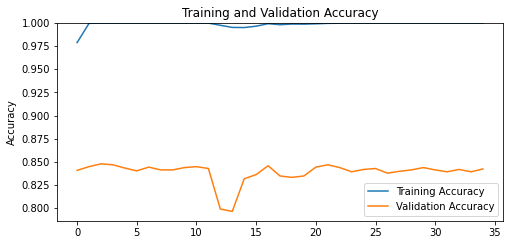

In [23]:
# Gráfica de la evolución de entrenamiento y validación durante las épocas
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')